In [2]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess
import numpy as np

# Cosine function that is fit to Rabi oscillations
def cos_func(
    drive_amp: float,
    frequency: float,
    amplitude: float,
    offset: float,
    phase: float = 0,
) -> float:
    return amplitude * np.cos(2 * np.pi * frequency * (drive_amp + phase)) + offset

class ChevronModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(cos_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)

        # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        self.set_param_hint("phase", min = -0.5, max = 0.5)

        # Pi-pulse amplitude can be derived from the oscillation frequency
        self.set_param_hint("swap", expr="1/(2*frequency)-phase", vary=False)
        self.set_param_hint("cz", expr="2/(2*frequency)-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("drive_amp", None)
        if drive_amp is None:
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=-2*amp_guess)
        self.set_param_hint("offset", value=offs_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
# from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
dp = r'data_directory/20231116/20231116-193100-532-78b293-cz_chevron/dataset.hdf5'
ds = load_dataset(dp)

In [5]:
qubit = 'q21'
freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
amp = ds[f'cz_pulse_durations{qubit}'].values*1e9
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = (magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes))

In [6]:
fit_results = []
for magnitude in magnitudes:
    model = ChevronModel()
    # magnitude = np.transpose(values)[15]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    guess = model.guess(magnitude, drive_amp=amp)
    fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
    fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
    fit_results.append(fit_result)
    # plt.plot(y,magnitude,'.r')
    # plt.plot(fit_amplitudes,fit_y,'--b')
qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
# opt_id = np.argmax(np.sum(qois,axis=1))
opt_id = np.argmin(np.diff(qois,axis=1))
opt_freq = freq[opt_id]
opt_cz = fit_results[opt_id].result.params['cz'].value
opt_swap = fit_results[opt_id].result.params['swap'].value
opt_id,opt_freq,opt_cz,opt_swap

(20, 1.5, 2969.7516497914867, 1484.6258256325762)

In [7]:
opt_cz_q21 = opt_cz

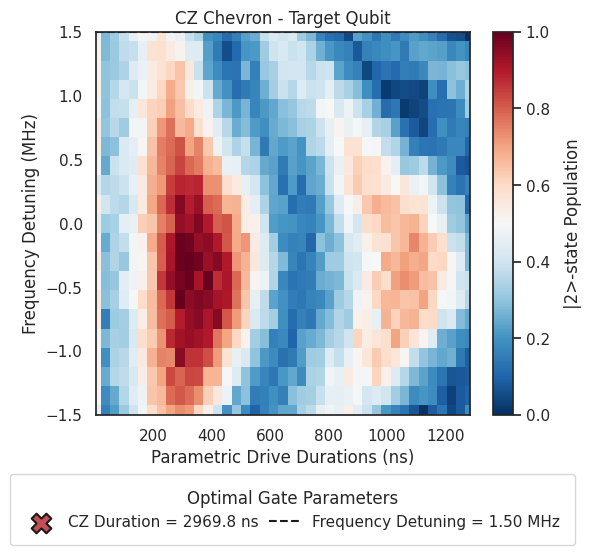

In [8]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
plt.figure(figsize=(6,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
plt.scatter(opt_cz,opt_freq,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
plt.vlines(opt_cz,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

plt.legend(loc = 'lower center', bbox_to_anchor=(-0.25, -0.36, 1.55, .102), mode='expand', ncol=2,
            title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('|2>-state Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Parametric Drive Durations (ns)')
plt.ylabel('Frequency Detuning (MHz)')
plt.title(f'CZ Chevron - Target Qubit')
plt.tight_layout()
plt.savefig(f'CZ Chevron {qubit}.png',dpi=300)
plt.show()

In [9]:
qubit = 'q22'
freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
amp = ds[f'cz_pulse_durations{qubit}'].values*1e9
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = (magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes))

In [10]:
fit_results = []
for magnitude in magnitudes:
    model = ChevronModel()
    # magnitude = np.transpose(values)[15]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    guess = model.guess(magnitude, drive_amp=amp)
    fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
    fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
    fit_results.append(fit_result)
    # plt.plot(y,magnitude,'.r')
    # plt.plot(fit_amplitudes,fit_y,'--b')
qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
opt_id = np.argmax(np.sum(qois,axis=1))
opt_freq = freq[opt_id]
opt_cz = fit_results[opt_id].result.params['cz'].value
opt_swap = fit_results[opt_id].result.params['swap'].value
opt_id,opt_freq,opt_cz,opt_swap

(8, -0.3, 728.538508680576, 364.51925425236783)

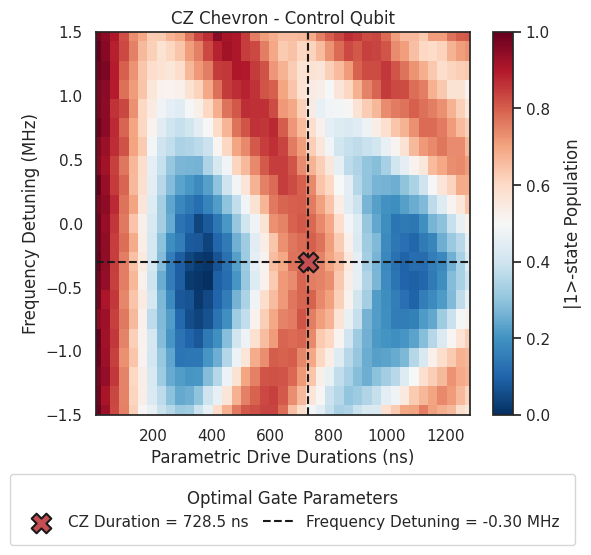

In [13]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
plt.figure(figsize=(6,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
plt.scatter(opt_cz,opt_freq,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
plt.vlines(opt_cz,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

plt.legend(loc = 'lower center', bbox_to_anchor=(-0.25, -0.36, 1.55, .102), mode='expand', ncol=2,
            title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('|1>-state Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Parametric Drive Durations (ns)')
plt.ylabel('Frequency Detuning (MHz)')
plt.title(f'CZ Chevron - Control Qubit')
plt.tight_layout()
plt.savefig(f'CZ Chevron {qubit}.png',dpi=300)
plt.show()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude    0.1402  -0.5022      inf   0.0179     True     None     None
cz             1031     -inf      inf    146.4    False 2/(2*frequency)-phase     None
frequency  0.0009703        0      inf 6.47e-05     True     None     None
offset       0.5913     -inf      inf  0.01383     True     None     None
phase          -0.5     -0.5      0.5    81.92     True     None     None
swap          515.8     -inf      inf    113.5    False 1/(2*frequency)-phase     None


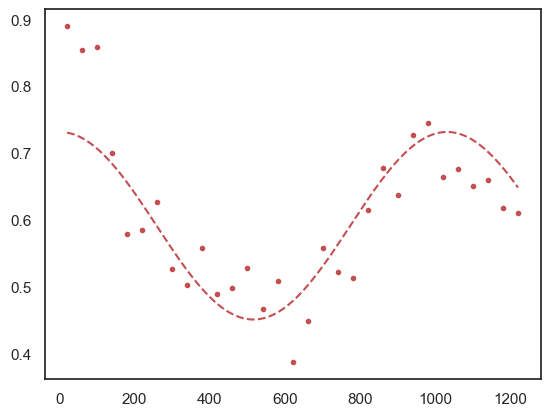

In [86]:
# model = ChevronModel()
# magnitude = magnitudes[0]
# fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
# guess = model.guess(magnitude, drive_amp=amp)
# fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
# fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
# fit_result.params.pretty_print()
# plt.plot(amp,magnitude,'.r')
# plt.plot(fit_amplitudes,fit_y,'--r')

# CZ

In [3]:
import lmfit
from quantify_core.analysis.fitting_models import fft_freq_phase_guess
import numpy as np

# Cosine function that is fit to Rabi oscillations
def cos_func(
    drive_amp: float,
    frequency: float,
    amplitude: float,
    offset: float,
    phase: float = 0,
) -> float:
    return amplitude * np.cos(2 * np.pi * frequency * (drive_amp + phase)) + offset

class CZModel(lmfit.model.Model):
    """
    Generate a cosine model that can be fit to Rabi oscillation data.
    """
    def __init__(self, *args, **kwargs):
        # Pass in the defining equation so the user doesn't have to later.
        super().__init__(cos_func, *args, **kwargs)

        # Enforce oscillation frequency is positive
        self.set_param_hint("frequency", min=0)

        # Fix the phase at pi so that the ouput is at a minimum when drive_amp=0
        self.set_param_hint("phase", min = 0, max = 360)

        # Pi-pulse amplitude can be derived from the oscillation frequency

        # self.set_param_hint("swap", expr="1/(2*frequency)-phase", vary=False)
        self.set_param_hint("cz", expr="2/(2*frequency)-phase", vary=False)


    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        drive_amp = kws.get("drive_amp", None)
        if drive_amp is None:
            return None

        amp_guess = abs(max(data) - min(data)) / 2  # amp is positive by convention
        offs_guess = np.mean(data)

        # Frequency guess is obtained using a fast fourier transform (FFT).
        (freq_guess, _) = fft_freq_phase_guess(data, drive_amp)

        self.set_param_hint("frequency", value=freq_guess, min=0)
        self.set_param_hint("amplitude", value=amp_guess, min=0)
        self.set_param_hint("offset", value=offs_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
# from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# dp = r'data_directory/20231108/20231108-165449-319-ec0bc2-cz_chevron/dataset.hdf5'
dp = r'dataset_cz.hdf5'
ds = load_dataset(dp)
ds

<xarray.Dataset>
Dimensions:           (ramsey_phasesq21: 51, control_onsq21: 2, ReIm: 2,
                       ramsey_phasesq22: 51, control_onsq22: 2)
Coordinates:
  * ramsey_phasesq21  (ramsey_phasesq21) float64 0.0 21.6 ... 1.058e+03 1.08e+03
  * ramsey_phasesq22  (ramsey_phasesq22) float64 0.0 21.6 ... 1.058e+03 1.08e+03
  * control_onsq21    (control_onsq21) bool False True
  * control_onsq22    (control_onsq22) bool False True
Dimensions without coordinates: ReIm
Data variables:
    yq21              (ramsey_phasesq21, control_onsq21, ReIm) float64 0.0081...
    yq22              (ramsey_phasesq22, control_onsq22, ReIm) float64 0.0052...
Attributes:
    name:     cz_calibration
    tuid:     20231115-014844-664-69eb06-cz_calibration

In [14]:
qubit = 'q21'
if int(qubit[1:]) % 2 == 0:
    print('even - target')
else:
    print('odd - control')

odd - control


In [5]:
qubit = 'q21'
freq = ds[f'control_ons{qubit}'].values
amp = ds[f'ramsey_phases{qubit}'].values
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = np.transpose((magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes)))

In [15]:
freq = ds[f'control_ons{qubit}'].values
amp = ds[f'ramsey_phases{qubit}'].values
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = np.transpose((magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes)))

fit_results,fit_ys = [],[]
fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
for magnitude in magnitudes:
    if int(qubit[1:]) % 2 == 0:
        fit = True
        model = CZModel()
        # magnitude = np.transpose(values)[15]
        guess = model.guess(magnitude, drive_amp=amp)
        fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
        fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
        fit_results.append(fit_result)
    else:
        fit = False
        fit_y = [np.mean(magnitude)]*400
    fit_ys.append(fit_y)
if fit:
    qois = np.transpose([[fit.result.params[p].value for p in ['cz']] for fit in fit_results])
    opt_cz = qois[0]
    cphase = np.abs(np.diff(opt_cz))[0]
else:
    cphase = 0
    opt_cz = [0]*2

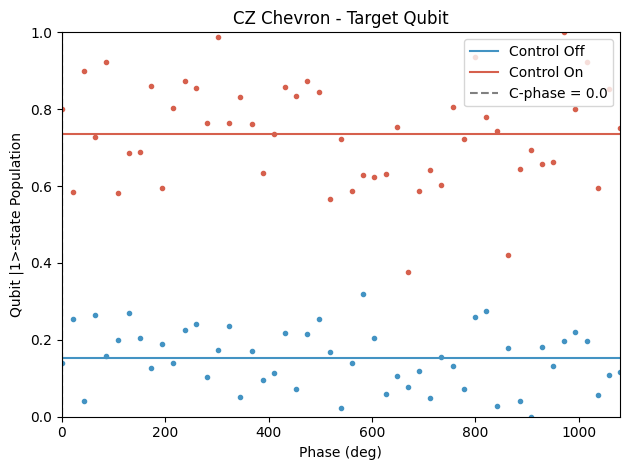

In [16]:
label = ['Control Off','Control On']
x = range(len(label))
colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 0.8, len(x)))

for index,magnitude in enumerate(magnitudes):
    plt.plot(amp,magnitude,'.',c = colors[index])
    plt.plot(fit_amplitudes,fit_ys[index],'-',c = colors[index],label = label[index])
    plt.vlines(opt_cz[index],-10,10,colors='gray',linestyles='--',linewidth=1.5)

plt.vlines(0,-10,-10,colors='gray',linestyles='--', label = 'C-phase = {:.1f}'.format(cphase),zorder=-10)
plt.legend(loc = 'upper right')
plt.xlim([amp[0],amp[-1]])
plt.ylim(np.min(magnitudes),np.max(magnitudes))
plt.xlabel('Phase (deg)')
plt.ylabel('Qubit |1>-state Population')
plt.title(f'CZ Chevron - Target Qubit')
plt.tight_layout()
plt.savefig(f'CZ calibration {qubit}.png',dpi=300)
plt.show()

In [191]:
np.abs(np.diff(qois)[0,0])

137.81911199901916

In [171]:
# qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
# qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
# # opt_id = np.argmax(np.sum(qois,axis=1))
# opt_id = np.argmin(np.diff(qois,axis=1))
# opt_freq = freq[opt_id]
# opt_cz = fit_results[opt_id].result.params['cz'].value
# opt_swap = fit_results[opt_id].result.params['swap'].value
# opt_id,opt_freq,opt_cz,opt_swap

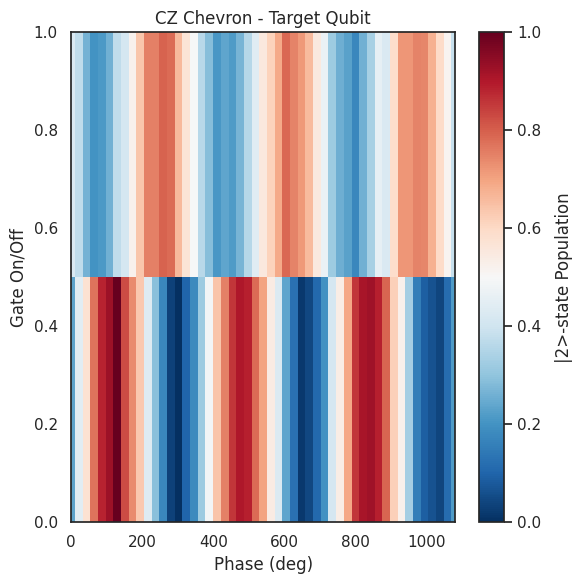

In [196]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
plt.figure(figsize=(6,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
# plt.scatter(opt_cz,opt_freq,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
# plt.vlines(opt_cz,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.15, -0.36, 1.4, .102), mode='expand', ncol=2,
#             title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('|2>-state Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Phase (deg)')
plt.ylabel('Gate On/Off')
plt.title(f'CZ Chevron - Target Qubit')
plt.tight_layout()
plt.savefig(f'CZ calibration {qubit}.png',dpi=300)
plt.show()

In [ ]:
qubit = 'q22'
freq = ds[f'cz_pulse_frequencies_sweep{qubit}'].values/1e6
amp = ds[f'cz_pulse_durations{qubit}'].values*1e9
magnitudes = np.array([[np.linalg.norm(u) for u in v] for v in ds[f'y{qubit}']])
magnitudes = (magnitudes - np.min(magnitudes))/(np.max(magnitudes)-np.min(magnitudes))

In [ ]:
fit_results = []
for magnitude in magnitudes:
    model = ChevronModel()
    # magnitude = np.transpose(values)[15]
    fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
    guess = model.guess(magnitude, drive_amp=amp)
    fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
    fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
    fit_results.append(fit_result)
    # plt.plot(y,magnitude,'.r')
    # plt.plot(fit_amplitudes,fit_y,'--b')
qois = np.transpose([[fit.result.params[p].value for p in ['amplitude','frequency']] for fit in fit_results])
qois = np.transpose([(q-np.min(q))/np.max(q) for q in qois])
opt_id = np.argmax(np.sum(qois,axis=1))
opt_freq = freq[opt_id]
opt_cz = fit_results[opt_id].result.params['cz'].value
opt_swap = fit_results[opt_id].result.params['swap'].value
opt_id,opt_freq,opt_cz,opt_swap

(11, -0.575, 1067.676579708564, 534.0882898578424)

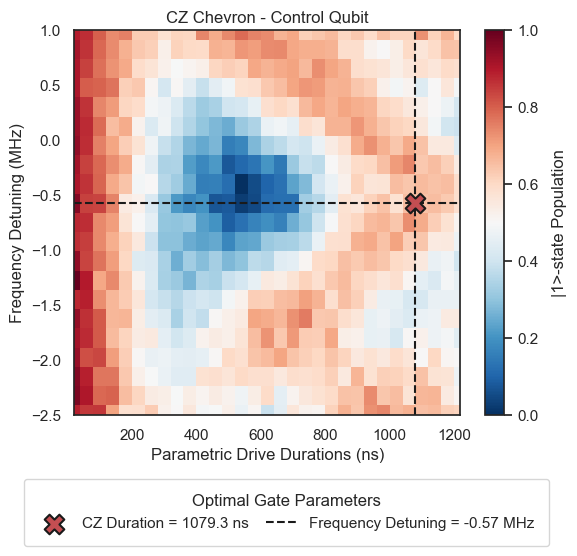

In [ ]:
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline
plt.figure(figsize=(6,6))
fig = plt.pcolormesh(amp,freq,magnitudes,shading='nearest',cmap='RdBu_r')
plt.scatter(opt_cz_q21,opt_freq,c='r',label = 'CZ Duration = {:.1f} ns'.format(opt_cz_q21),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
# plt.scatter(opt_swap,opt_freq,c='b',label = 'SWAP12 Duration= {:.2f} V'.format(opt_swap),marker='X',s=200,edgecolors='k', linewidth=1.5,zorder=10)
plt.hlines(opt_freq,amp[0],amp[-1],label = 'Frequency Detuning = {:.2f} MHz'.format(opt_freq),colors='k',linestyles='--',linewidth=1.5)
plt.vlines(opt_cz_q21,freq[0],freq[-1],colors='k',linestyles='--',linewidth=1.5)

plt.legend(loc = 'lower center', bbox_to_anchor=(-0.15, -0.36, 1.4, .102), mode='expand', ncol=2,
            title = 'Optimal Gate Parameters', columnspacing=200,borderpad=1)
# plt.legend(loc = 'lower center', bbox_to_anchor=(-0.037, -0.3, 1.2, .102), mode='expand', ncol=3,
#                     title = 'Optimal Gate Parameters', columnspacing=100,borderpad=1)
cbar = plt.colorbar(fig)
cbar.set_label('|1>-state Population', labelpad=10)
plt.ylim([freq[0],freq[-1]])
plt.xlim([amp[0],amp[-1]])
plt.xlabel('Parametric Drive Durations (ns)')
plt.ylabel('Frequency Detuning (MHz)')
plt.title(f'CZ Chevron - Control Qubit')
plt.tight_layout()
plt.savefig(f'CZ Chevron {qubit}.png',dpi=300)
plt.show()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude    0.1402  -0.5022      inf   0.0179     True     None     None
cz             1031     -inf      inf    146.4    False 2/(2*frequency)-phase     None
frequency  0.0009703        0      inf 6.47e-05     True     None     None
offset       0.5913     -inf      inf  0.01383     True     None     None
phase          -0.5     -0.5      0.5    81.92     True     None     None
swap          515.8     -inf      inf    113.5    False 1/(2*frequency)-phase     None


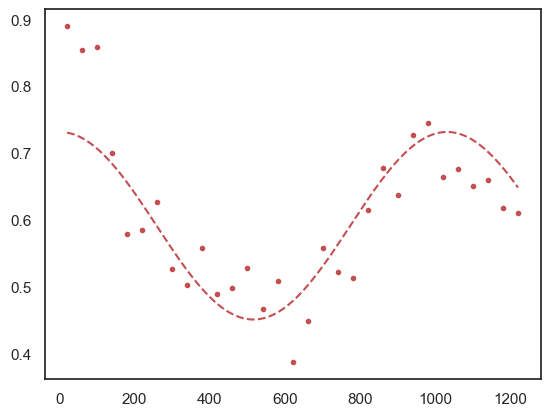

In [ ]:
# model = ChevronModel()
# magnitude = magnitudes[0]
# fit_amplitudes = np.linspace( amp[0], amp[-1], 400)
# guess = model.guess(magnitude, drive_amp=amp)
# fit_result = model.fit(magnitude, params=guess, drive_amp=amp)
# fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: fit_amplitudes})
# fit_result.params.pretty_print()
# plt.plot(amp,magnitude,'.r')
# plt.plot(fit_amplitudes,fit_y,'--r')